In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
LOGFILE = 'Out/test-06.csv'
data = pd.read_csv(LOGFILE)
data

,episode,step_count,wall_collisions,box_collisions,train_loss,reward
0,0,0,0,0,0.0,0.000000
1,1,0,1,0,-5.0,0.000000
2,2,0,4,0,12.0,0.000000
3,3,0,11,1,27.0,0.000000
4,4,0,12,1,22.0,0.000000
...,...,...,...,...,...,...
744,744,49564,825,584,385790.0,4288.067981
745,745,49600,825,585,386076.0,4289.322345
746,746,49867,830,586,388231.0,4296.309040
747,747,49965,830,587,389060.0,4299.237347


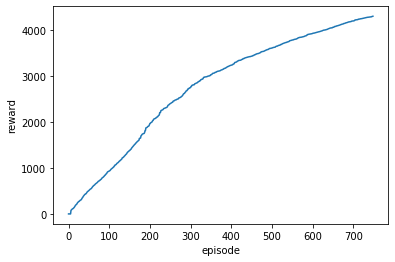

In [3]:
sns.lineplot(data=data,x='episode',y='reward')

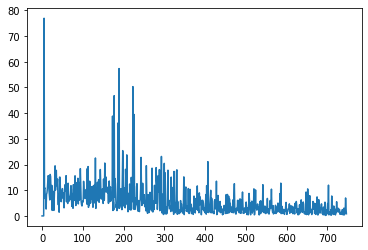

In [8]:
plt.plot(np.diff(data.reward))

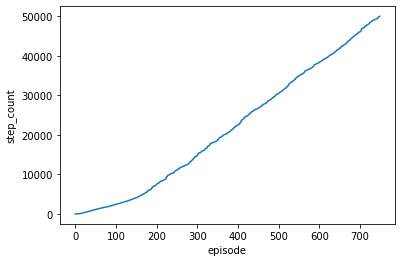

In [4]:
sns.lineplot(data=data,x='episode',y='step_count')

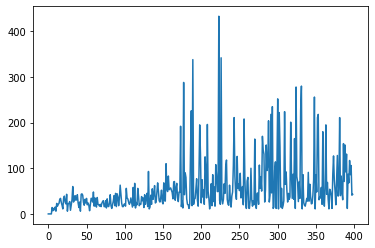

In [6]:
plt.plot(np.diff(data.step_count[:400]))

In [9]:
# local files
import os, sys
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition

import torch
import cv2
from itertools import count

In [7]:
# Utilities
def process_state(state_raw):
    """ @TODO 
    - Image processing
    - Phosphene simulation
    - Frame stacking
    """
    frame = environment.state2usableArray(state_raw)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame.astype('float32')
    return torch.Tensor(frame / 255.).view(1,1,environment.size, environment.size)

In [4]:
# Training parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.999
EPS_START = 0.
EPS_END = 0.
EPS_DECAY = 0.
DEVICE = 'cpu'
LR_DQN = 0.01

# Environment parameters
IMSIZE = 128
STACK_SIZE = 1
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 
agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=12000,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)

In [12]:
## Some more training parameters 
MAX_EPISODES = 5 # number of episodes (an episode ends after agent hits a box)
TRAINING_CONDITION = 0 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing

MODEL_PATH = 'Out/test-04.pth'


# How to handle the different end signals
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:False}  # Reached step target


# Load saved model
agent.policy_net.load_state_dict(torch.load(MODEL_PATH,map_location=DEVICE))


# Reset counters 
wall_collisions = 0
box_collisions = 0
total_reward = 0
total_loss = 0

for episode in range(int(MAX_EPISODES)):
    
    # Reset environment at start of episode
    _, _, state_raw = environment.reset(TRAINING_CONDITION)
    state = process_state(state_raw).to(DEVICE)
    
    # Episode starts here:
    for t in count(): 
        
        # 1. Agent performs a step (based on the current state) and obtains next state
        action = agent.select_action(state)
        end, reward, next_state_raw = environment.step(action.item())
        next_state = process_state(next_state_raw).to(DEVICE) if not RESET_UPON_END_SIGNAL[end] else None
        
            
        # 2. Store performance and training measures
        total_reward += reward;
        if end == 1:
            box_collisions += 1
        if end == 2:
            wall_collisions +=1
        
        # 3. the episode ends here if agent performed any 'lethal' action (specified in RESET_UPON_END_SIGNAL)
        if RESET_UPON_END_SIGNAL[end]:
            break
        else:
            state = next_state

KeyboardInterrupt: 